In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk
import time 
import sys
import os 

In [16]:
# Load the DICOM image
file_path = "Photos/1-2.dcm"
image = sitk.ReadImage(file_path)

# Save image metadata
metadata = {}
for key in image.GetMetaDataKeys():
    metadata[key] = image.GetMetaData(key)

# Convert the SimpleITK image to a numpy array
img = sitk.GetArrayFromImage(image)[0]

In [17]:
# Convert to grayscale if the image is in color
if len(img.shape) == 3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    gray_img = img

# Preprocessing: enhance contrast and smooth
gray_img = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

# Threshold to create a binary image
_, binary_img = cv2.threshold(blurred_img, 10, 255, cv2.THRESH_BINARY)

# Detect contours in the binary image
contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours: keep only large regions and exclude rectangular text/overlays
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)

    # Conditions to filter out text or rectangular overlays:
    # - Exclude small areas that are likely text
    # - Keep contours that are large or have irregular shapes
    if cv2.contourArea(contour) > 100750 and (0.5 < aspect_ratio < 5.0):  # Adjust these thresholds as needed
        filtered_contours.append(contour)

# Create a mask to isolate only the main ultrasound shape
ultrasound_mask = np.zeros_like(binary_img)
cv2.drawContours(ultrasound_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

# Apply the mask to keep only the filtered regions
isolated_ultrasound = cv2.bitwise_and(gray_img, gray_img, mask=ultrasound_mask)

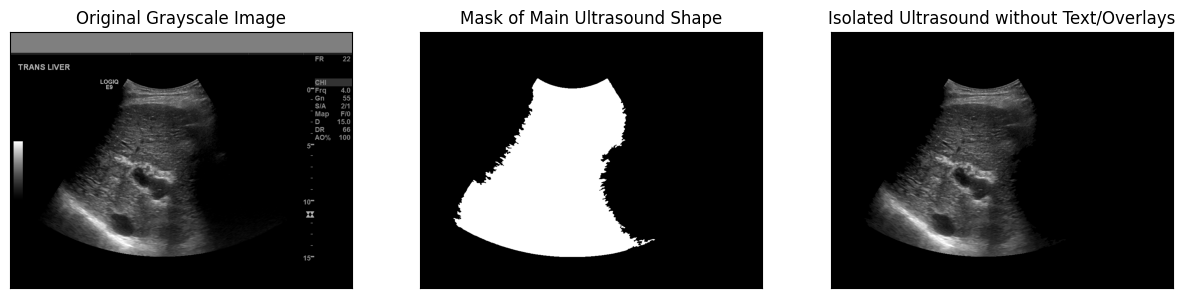

In [18]:
# Display results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Grayscale Image')
plt.xticks([]), plt.yticks([])

plt.subplot(132)
plt.imshow(ultrasound_mask, cmap='gray')
plt.title('Mask of Main Ultrasound Shape')
plt.xticks([]), plt.yticks([])

plt.subplot(133)
plt.imshow(isolated_ultrasound, cmap='gray')
plt.title('Isolated Ultrasound without Text/Overlays')
plt.xticks([]), plt.yticks([])

plt.show()


In [19]:
# Save the isolated ultrasound image
output_path = "Processed Images/1-2.png"
cv2.imwrite(output_path, isolated_ultrasound)

True